In [1]:
import torch
import torch.nn as nn
from dataset import camvidLoader
from network import SegmentationNetwork

/~/HDD1/ypang6/anaconda3/envs/pyrahul/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1
# set random seed for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Load model
num_classes = 12

net = SegmentationNetwork(num_classes=num_classes, p = 0.5, backbone = 'resnet50', pretrained = True)

/~/HDD1/ypang6/anaconda3/envs/pyrahul/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/~/HDD1/ypang6/anaconda3/envs/pyrahul/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Load model weights
def load_model_weights(net, path):
    state_dict = torch.load(path)
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    net.load_state_dict(state_dict)
    return net

In [4]:
# Load test dataset
root_dir = "/~/HDD1/rrathnak/CAAP_Stereo/Datasets/CamVid"
crop_size = 224

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

data_transforms = A.Compose(
    [
        A.Resize(crop_size, crop_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

In [5]:
import numpy as np
from torchmetrics import F1Score, Accuracy, PrecisionRecallCurve, CalibrationError
from netcal.metrics import ECE

# Metrics for evaluation
F1_score = F1Score(mdmc_average='samplewise', average = 'macro',num_classes=num_classes)
F1_score_classwise = F1Score(average = 'none', num_classes = num_classes, mdmc_average='samplewise')
accuracy = Accuracy(mdmc_average='samplewise', num_classes = num_classes, average = 'macro')
accuracy_classwise = Accuracy(average = 'none', num_classes = num_classes, mdmc_average='samplewise')

In [6]:
# Import some additional stuff
# from netcal.scaling import TemperatureScaling
# from netcal.metrics import ECE
# from netcal.presentation import ReliabilityDiagram

def test(
    net, test_loader, num_classes, mc_samples, train_len,
    summary_logger, device, 
    F1_score, F1_score_classwise, accuracy, accuracy_classwise
):
    # Batchwise_* is a list of size num_batches
    batchwise_F1 = []
    batchwise_F1_classwise = []
    batchwise_accuracy = []
    batchwise_accuracy_classwise = []
    batchwise_epistemic = []
    batchwise_epistemic_classwise = []
    batchwise_aleatoric = []
    batchwise_aleatoric_classwise = []
    batchwise_ece = []
    batchwise_entropy = []
    softmax = nn.Softmax(dim = 1)
    with torch.no_grad():
        for iter, (input_data, target) in enumerate(test_loader):
            # Inside a batch
            sampled_outs = []
            means = []
            means_noSoftmax = []
            sample_F1 = []
            sample_F1_classwise = []
            sample_accuracy = []
            sample_accuracy_classwise = []
            sample_ece = []
            input_data = input_data.to(device)
            target = target.to(device)
            # Predicted aleatoric variance from a single pass
            batch_aleatoric_uncertainty = net(input_data)[:, num_classes:, :, :]
            assert batch_aleatoric_uncertainty.shape[1] == num_classes, "Aleatoric uncertainty shape error."
            batch_aleatoric_uncertainty = np.exp(batch_aleatoric_uncertainty.detach().clone().cpu().numpy())
            for i in range(mc_samples):
                # Iterate over MC samples
                sampled_outs.append(net(input_data))
            for out in sampled_outs:
                # For each sample, compute metrics for the mean prediction
                N, C, H, W = out.shape
                mean = out[:, :num_classes, :, :]
                # append mean prediction to list
                means_noSoftmax.append(mean.detach().clone().cpu().numpy())
                mean = softmax(mean)
                assert torch.allclose(mean.sum(dim = 1), torch.ones(N, H, W).to(device)), "AssertionError: Probabilities do not sum to 1"
                means.append(mean.detach().clone().cpu().numpy())
                f1_score = F1_score(mean.detach().cpu(), target.cpu()).numpy()
                f1_score_ = F1_score(out[:, :num_classes, :, :].detach().cpu(), target.cpu()).numpy()
                assert np.allclose(f1_score, f1_score_), "AssertionError: F1 score is not the same between softmax mean and out"
                f1_score_classwise = F1_score_classwise(mean.detach().cpu(), target.cpu()).numpy()
                acc = accuracy(mean.detach().cpu(), target.cpu()).numpy()
                acc_classwise = accuracy_classwise(mean.detach().cpu(), target.cpu()).numpy()
                sample_F1.append(f1_score)
                sample_F1_classwise.append(f1_score_classwise)
                sample_accuracy.append(acc)
                sample_accuracy_classwise.append(acc_classwise)
                # compute ECE
                # temperature = TemperatureScaling()
                # temperature.fit(mean.detach().cpu().numpy(), target.cpu().numpy())
                # calibrated = temperature.transform(mean.detach().cpu().numpy())
                n_bins = 10
                ece = CalibrationError(n_bins)
                ece.update(mean.detach().cpu(), target.cpu())
                sample_ece.append(ece.compute())
            # Computation for the batch is complete - append to list
            batch_mean = np.mean(np.stack(means), axis = 0)
            N, C, H, W = batch_mean.shape
            pred = batch_mean.transpose(0, 2, 3, 1).reshape(-1, num_classes).argmax(axis = 1).reshape(N, H, W)
            batch_F1 = np.mean(sample_F1, axis = 0)
            batch_F1_classwise = np.mean(sample_F1_classwise, axis = 0)
            batch_accuracy = np.mean(sample_accuracy, axis = 0)
            batch_accuracy_classwise = np.mean(sample_accuracy_classwise, axis = 0)
            batch_epistemic_uncertainty = np.var(np.stack(means), axis = 0)
            batch_epistemic_uncertainty_v2 = 1/mc_samples * np.sum(np.square(np.stack(means) - batch_mean), axis = 0)
            assert np.allclose(batch_epistemic_uncertainty, batch_epistemic_uncertainty_v2), "AssertionError: Epistemic uncertainty is not the same between two methods"
            # Compute entropy of the mean prediction
            batch_entropy = -np.sum(batch_mean * np.log(batch_mean), axis = 1)
            batch_epistemic_uncertainty_classwise = np.mean(batch_epistemic_uncertainty, axis = (0,2,3))
            batch_aleatoric_uncertainty_classwise = np.mean(batch_aleatoric_uncertainty, axis = (0,2,3))
            batch_ece = np.mean(sample_ece, axis = 0)
            # Append batch metrics to list (batchwise_*)
            batchwise_F1.append(batch_F1)
            batchwise_F1_classwise.append(batch_F1_classwise)
            batchwise_accuracy.append(batch_accuracy)
            batchwise_accuracy_classwise.append(batch_accuracy_classwise)
            batchwise_epistemic.append(batch_epistemic_uncertainty)
            batchwise_epistemic_classwise.append(batch_epistemic_uncertainty_classwise)
            batchwise_aleatoric.append(batch_aleatoric_uncertainty)
            batchwise_aleatoric_classwise.append(batch_aleatoric_uncertainty_classwise)
            batchwise_ece.append(batch_ece)
            batchwise_entropy.append(batch_entropy)
    # compute the average accuracy and f1 score for the entire TEST SET
    epoch_acc = np.mean(batchwise_accuracy)
    epoch_F1 = np.mean(batchwise_F1)
    epoch_classwise_F1 = np.mean(batchwise_F1_classwise, axis = 0)
    epoch_classwise_accuracy = np.mean(batchwise_accuracy_classwise, axis = 0)
    epoch_epistemic = np.mean(np.vstack(batchwise_epistemic))
    epoch_entropy = np.mean(np.vstack(batchwise_entropy))
    epoch_epistemic_classwise = np.mean(batchwise_epistemic_classwise, axis = 0)
    epoch_aleatoric = np.mean(np.vstack(batchwise_aleatoric))
    epoch_aleatoric_classwise = np.mean(batchwise_aleatoric_classwise, axis = 0)
    epoch_ece = np.mean(np.vstack(batchwise_ece))
    print("Length of training set:{}".format(train_len))
    print("Accuracy: {} | F1: {}".format(epoch_acc, epoch_F1))
    print("Epistemic Uncertainty: {} | Entropy: {} | Aleatoric Uncertainty: {}".format(epoch_epistemic, epoch_entropy,epoch_aleatoric))
    return epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1

Length of training set:None
Accuracy: 0.34113115072250366 | F1: 0.26581311225891113
Epistemic Uncertainty: 0.0017308599781244993 | Entropy: 0.9201635122299194 | Aleatoric Uncertainty: 1.0123096704483032
Length of training set:None
Accuracy: 0.25467929244041443 | F1: 0.16814762353897095
Epistemic Uncertainty: 0.0024894264061003923 | Entropy: 0.9556307792663574 | Aleatoric Uncertainty: 1.013838768005371
Length of training set:None
Accuracy: 0.2880926728248596 | F1: 0.21236318349838257
Epistemic Uncertainty: 0.00239971443079412 | Entropy: 0.7273709177970886 | Aleatoric Uncertainty: 1.004733920097351
Length of training set:None
Accuracy: 0.30943331122398376 | F1: 0.2326550930738449
Epistemic Uncertainty: 0.00155112415086478 | Entropy: 0.7120630741119385 | Aleatoric Uncertainty: 0.9963534474372864
Length of training set:None
Accuracy: 0.27328404784202576 | F1: 0.22098854184150696
Epistemic Uncertainty: 0.0015672374283894897 | Entropy: 0.5868914127349854 | Aleatoric Uncertainty: 1.0095206499

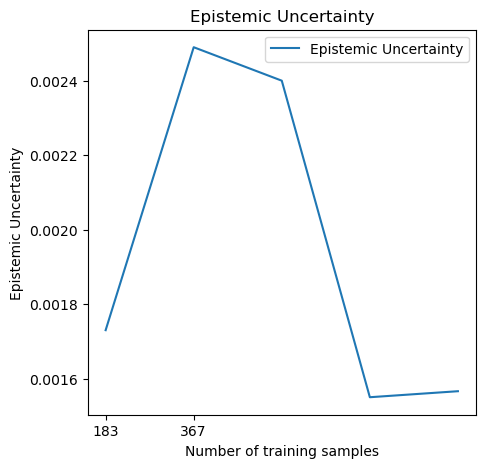

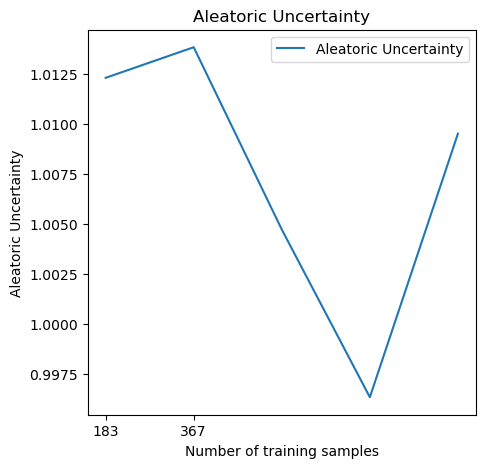

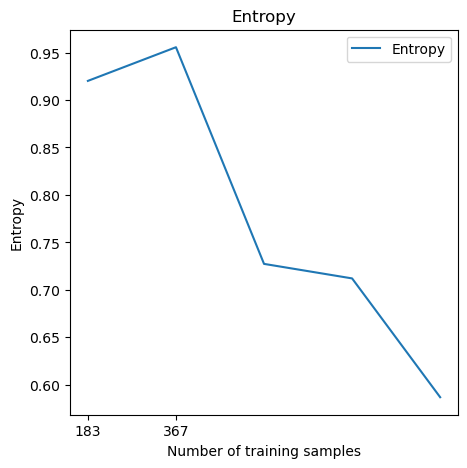

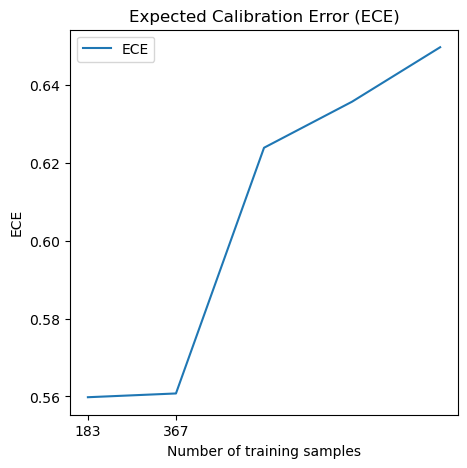

In [7]:
torch.cuda.empty_cache() 
# Iterate over all saved models and compute metrics
model_paths = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-12-21_resnet50_CamVid_45Train/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-12-21_resnet50_CamVid_91Train/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-12-21_resnet50_CamVid_183Train/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-12-21_resnet50_CamVid_275Train/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-12-20_resnet50_CamVid_allTrain/best/best_model.pth',
]
model_F1 = []
model_classwise_accuracy = []
model_classwise_F1 = []
model_epistemic = []
model_entropy = []
model_epistemic_classwise = []
model_aleatoric = []
model_aleatoric_classwise = []
model_ece = []

dataparallel = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model_path in model_paths:
    net = load_model_weights(net, model_path)
    test_dataset = camvidLoader(root = root_dir, is_transform=True, transforms=data_transforms, split = 'test', sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    net.to(device)
    net.eval()
    if dataparallel:
        net = nn.DataParallel(net, device_ids = [0,1,2,3,4,5,6,7])
    if dataparallel == True:
        net.module.dropout.train() # Turn on MC Dropout
    else:
        net.dropout.train()
    mc_samples = 25
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_F1.append(epoch_F1)
    # model_classwise_accuracy.append(epoch_classwise_accuracy)
    # model_classwise_F1.append(epoch_classwise_F1)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    # model_epistemic_classwise.append(epoch_epistemic_classwise)
    model_aleatoric.append(epoch_aleatoric)
    # model_aleatoric_classwise.append(epoch_aleatoric_classwise)
    model_ece.append(epoch_ece)
import matplotlib.pyplot as plt
# Plot episitmic uncertainty
model_epistemic = np.array(model_epistemic)
fig = plt.figure(figsize = (5,5))
plt.plot(model_epistemic, label = 'Epistemic Uncertainty')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty')
plt.xticks([0,1], ['183', '367'])
plt.show()

# Plot aleatoric uncertainty
model_aleatoric = np.array(model_aleatoric)
fig = plt.figure(figsize = (5,5))
plt.plot(model_aleatoric, label = 'Aleatoric Uncertainty')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')
plt.xticks([0,1], ['183', '367'])
plt.show()

# Plot entropy
model_entropy = np.array(model_entropy)
fig = plt.figure(figsize = (5,5))
plt.plot(model_entropy, label = 'Entropy')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.xticks([0,1], ['183', '367'])
plt.show()

# Plot expected calibration error
model_ece = np.array(model_ece)
fig = plt.figure(figsize = (5,5))
plt.plot(model_ece, label = 'ECE')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('ECE')
plt.title('Expected Calibration Error (ECE)')
plt.xticks([0,1], ['183', '367'])
plt.show()


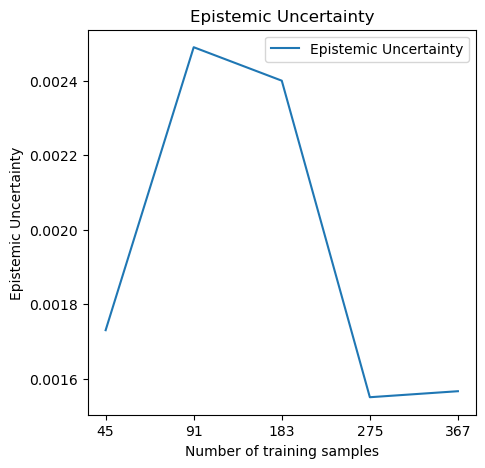

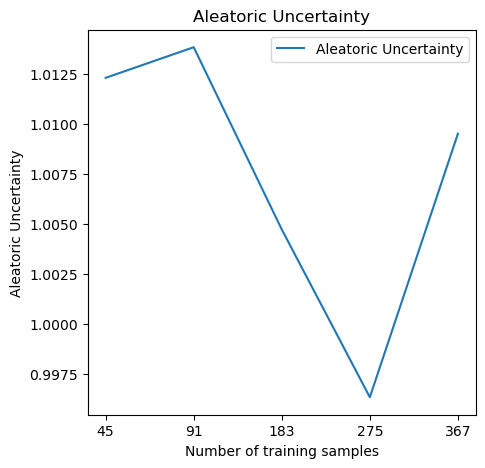

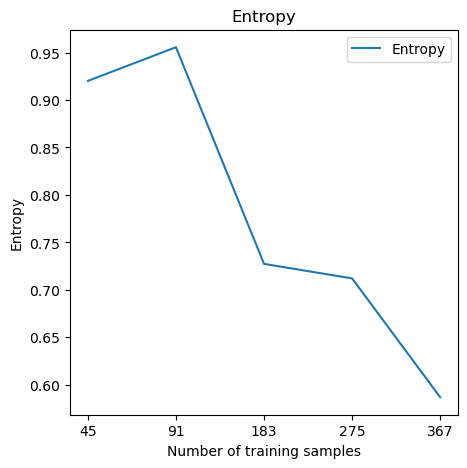

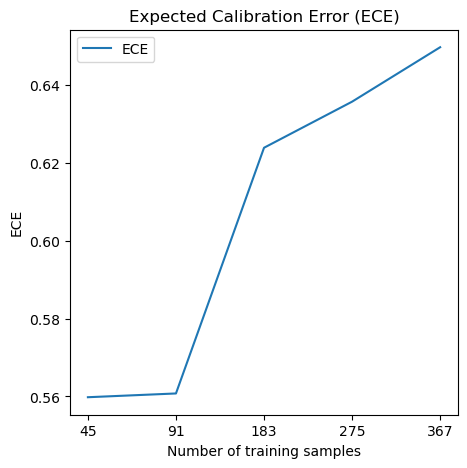

In [9]:
import matplotlib.pyplot as plt
# Plot episitmic uncertainty
model_epistemic = np.array(model_epistemic)
fig = plt.figure(figsize = (5,5))
plt.plot(model_epistemic, label = 'Epistemic Uncertainty')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty')
plt.xticks([0,1,2,3,4], ['45', '91', '183', '275', '367'])
plt.show()

# Plot aleatoric uncertainty
model_aleatoric = np.array(model_aleatoric)
fig = plt.figure(figsize = (5,5))
plt.plot(model_aleatoric, label = 'Aleatoric Uncertainty')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')
plt.xticks([0,1,2,3,4], ['45', '91', '183', '275', '367'])
plt.show()

# Plot entropy
model_entropy = np.array(model_entropy)
fig = plt.figure(figsize = (5,5))
plt.plot(model_entropy, label = 'Entropy')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.xticks([0,1,2,3,4], ['45', '91', '183', '275', '367'])
plt.show()

# Plot expected calibration error
model_ece = np.array(model_ece)
fig = plt.figure(figsize = (5,5))
plt.plot(model_ece, label = 'ECE')
plt.legend()
plt.xlabel('Number of training samples')
plt.ylabel('ECE')
plt.title('Expected Calibration Error (ECE)')
plt.xticks([0,1,2,3,4], ['45', '91', '183', '275', '367'])
plt.show()